# Convolutional Neural Networks
---

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import os

from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split

---
## Convolutional Layer Implementation

---
### Padding

**Exercise 1 [3/3]**:
1. Implement the zero_pad() function, which takes a batch of examples A and a padding parameter p.
2. Adds zeros around all four edges of each example.

In [2]:
def zero_pad(A, pad):

    A_padded = np.pad(A, ((0, ), (pad, ), (pad, )), mode = 'constant', constant_values = 0)

    return A_padded

In [3]:
# Define the size of the image and batch
n = 3
batch_size = 10

In [4]:
# Generate a batch of random images
np.random.seed(1)
X = np.random.randn(batch_size, n, n)

In [5]:
print(f"Original Image X[1]: \n{X[1]}")

Original Image X[1]: 
[[-0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944]
 [-1.09989127 -0.17242821 -0.87785842]]


In [6]:
pad = 1 # Padding size
X_padded = zero_pad(X, pad) # Apply zero-padding

In [7]:
print(f"Padded Image X_padded[1]: \n{X_padded[1]}")

Padded Image X_padded[1]: 
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -0.24937038  1.46210794 -2.06014071  0.        ]
 [ 0.         -0.3224172  -0.38405435  1.13376944  0.        ]
 [ 0.         -1.09989127 -0.17242821 -0.87785842  0.        ]
 [ 0.          0.          0.          0.          0.        ]]


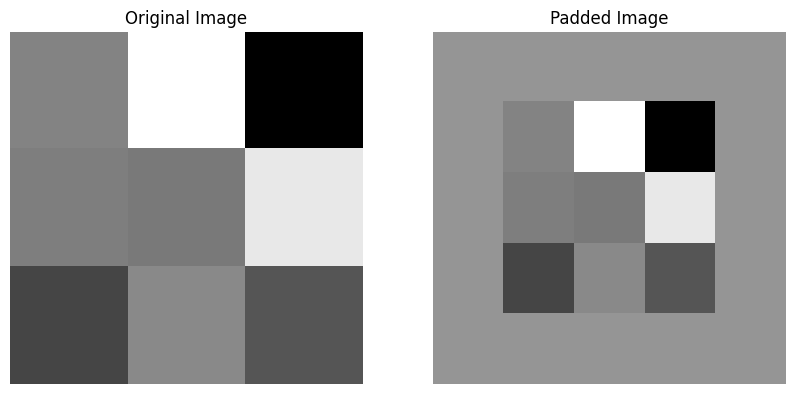

In [8]:
# Visualizing the original and padded images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(X[1], cmap = 'gray') # Show original image
ax1.set_title("Original Image")
ax1.axis('off')
ax2.imshow(X_padded[1], cmap = 'gray') # Show padded image
ax2.set_title("Padded Image")
ax2.axis('off')
plt.show()

---
### One Step Convolution

**Exercise 2 [3/3]**:
1. Implement the `one_step_conv()` function. This function should take a region from the padded input, a filter, and a bias term as inputs, and it should return the result of the convolution operation for that specific region.

In [9]:
def one_step_conv(region, filter, bias):

    # Element-wise multiplication and summation
    result = np.sum(region * filter) + bias

    return result.item()

In [10]:
# Define filter parameters
i = 0
j = 0
filter_size = 3
bias = 0

In [11]:
# Define a simple edge-detection filter
filter = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

In [12]:
# Extract the 3x3 region from the padded image
A_padded = X_padded[1]
region = A_padded[i:i + filter_size, j:j + filter_size]

In [13]:
# Perform one-step convolution
output = one_step_conv(region, filter, bias)

In [14]:
print(f"Region = \n{region}")
print(f"Output of one_step_conv: {output}")

Region = 
[[ 0.          0.          0.        ]
 [ 0.         -0.24937038  1.46210794]
 [ 0.         -0.3224172  -0.38405435]]
Output of one_step_conv: -1.0780535823765585


---
### Stride

**Exercise 3 [4/4]**:
1. Implement the get_region() function, which extracts and returns the appropriate region from the padded input  `A_padded`  based on the current  `(i,j)`, `stride`, and `filter_size`.

In [15]:
def get_region(A_padded, i, j, stride, filter_size):

    i_start = i * stride # Compute row start index based on stride
    j_start = j * stride # Compute column start index based on stride
    region = A_padded[i_start:i_start + filter_size, j_start:j_start + filter_size] # Extract region

    return region

In [16]:
# Define initial indices and stride
i = 0
j = 0
stride = 2

In [17]:
get_region(A_padded, i, j, stride, filter_size)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.24937038,  1.46210794],
       [ 0.        , -0.3224172 , -0.38405435]])

---
### Forward Pass

**Exercise 4 [10/10]**:
1. Implement the `conv_forward()` function. Assume using `ReLU()`. The function should return both `A` (the activated output feature map) and a `cache` containing `A_prev` and `Z`, which will be essential for backpropagation.

In [18]:
class ReLU:

    def __init__(self):
        pass

    def forward(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x >= 0, 1, 0)

    def __call__(self, x):
        return self.forward(x)

In [19]:
def conv_forward(A_prev, filter, bias, stride = 1, pad = 0, act = ReLU()):

    batch_size = A_prev.shape[0] # Number of images in the batch
    n = A_prev.shape[1] # Input image size
    f = filter.shape[0] # Filter size
    m = (n + 2 * pad - f) // stride + 1 # Compute output spatial size

    # Initialize output volume
    Z = np.zeros((batch_size, m, m))

    # Apply zero-padding to the input images
    A_padded = zero_pad(A_prev, pad)

    for b in range(batch_size): # Iterate over batch
        for i in range(m): # Iterate over rows of output
            for j in range(m): # Iterate over columns of output
                region = get_region(A_padded[b], i, j, stride, f) # Extract region
                Z[b, i, j] = one_step_conv(region, filter, bias) # Apply convolution

    # Apply activation function
    A = act(Z)

    # Store cache for potential backward pass
    cache = (A_prev, Z)

    return A, cache

In [20]:
act = ReLU()
A, cache = conv_forward(X, filter, bias, stride, pad, act)

In [21]:
print(f'A[1] = \n{A[1]}')

A[1] = 
[[0.         1.07805358]
 [0.55648256 0.        ]]


---
### Backward Pass

**Exercise 5 [15/15]**:
1. Implement `conv_backward()`. This function will calculate $dA^{\ell-1}$,  $dF^{\ell}$, and $db^{\ell}$ using the steps outlined above. Remember that $dA^{\ell-1}$ must be accumulated over all regions that contributed to each element in the output.

In [22]:
def conv_backward(dA, filter, bias, cache, act = ReLU(), stride = 1, pad = 0):

    # Retrieve cached values from forward pass
    A_prev, Z = cache

    batch_size = A_prev.shape[0] # Number of input samples
    n = A_prev.shape[1] # Input image size
    f = filter.shape[0] # Filter size
    m = (n + 2 * pad - f) // stride + 1 # Output spatial size

    # Initialize gradients
    dF = np.zeros_like(filter, dtype = np.float64)
    db = np.zeros_like(bias, dtype = np.float64)
    dA_prev = np.zeros_like(A_prev, dtype = np.float64)

    # Apply padding to A_prev and dA_prev if necessary
    if pad > 0:
        A_prev_padded = zero_pad(A_prev, pad)
        dA_prev_padded = zero_pad(A_prev, pad)
    else:
        A_prev_padded = A_prev
        dA_prev_padded = dA_prev

    # Compute dZ using the derivative of the activation function
    dZ = act.derivative(Z) * dA

    for b in range(batch_size): # Iterate over batch
        for i in range(m): # Iterate over output rows
            for j in range(m): # Iterate over output columns
                region = get_region(A_prev_padded[b], i, j, stride, f) # Extract corresponding region from the padded input
                dF += region * dZ[b, i, j] # Compute gradients for filter
                db += dZ[b, i, j] # Compute gradients for bias
                dA_prev_padded[b, i * stride:i * stride + f, j * stride:j * stride + f] += filter * dZ[b, i, j] # Distribute gradient to the corresponding area in dA_prev_padded

    # Remove padding from dA_prev if padding was applied
    if pad > 0:
        dA_prev = dA_prev_padded[pad:-pad, pad:-pad]
    else:
        dA_prev = dA_prev_padded

    return dA_prev, dF, db

In [23]:
dA = np.random.randn(*A.shape)
dA_prev, dF, db = conv_backward(dA, filter, bias, cache, act, stride, pad)

In [24]:
print("dA[1] (Upstream gradient):\n", dA[1])
print("dA_prev[1] (Gradient wrt A_prev):\n", dA_prev[1])
print("dF (Gradient wrt filter):\n", dF)
print("db (Gradient wrt bias):\n", db)

dA[1] (Upstream gradient):
 [[ 0.42349435  0.07734007]
 [-0.34385368  0.04359686]]
dA_prev[1] (Gradient wrt A_prev):
 [[ 0.          0.04221375  1.28084725 -1.10061918 -0.69803203]
 [ 0.          1.14472371  2.82413046  0.50249434 -1.92253974]
 [ 0.          0.90085595  0.54077985 -0.12289023 -1.2245077 ]]
dF (Gradient wrt filter):
 [[-1.37033461  0.34640552  1.08872162]
 [ 1.30614291 -1.78087485 -0.28059913]
 [ 0.8219175   1.8084983  -0.16008673]]
db (Gradient wrt bias):
 1.8615718689004241


---
### Flattening

**Exercise 6 [1/1]**:
1. Implement the `flatten()` method to reshape the output from the convolutional layer into a one-dimensional vector. This step is essential for transitioning from the convolutional structure to the fully connected layers in your CNN.

In [25]:
def flatten(A):

    batch_size = A.shape[0] # Number of samples in the batch
    m = A.shape[1] # Height
    A_flattened = A.reshape(batch_size, -1) # Reshape the 3D input

    return A_flattened

In [26]:
np.random.seed(1)
A = np.random.randn(batch_size, 5, 5)
a = flatten(A)

In [27]:
print(a.shape)
print(a[0])

(10, 25)
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595]


---
### Fully Connected Layer

**Exercise 7 [5/5]**:
1. Implement the `FCN()` and `FCN_backward()`.

In [28]:
def FCN(A_prev, W, b, act = ReLU()):

    Z =  np.dot(A_prev, W.T) + b.T # Compute the linear transformation
    A = act(Z) # Apply activation function
    cache = (A_prev, Z) # Store values for backward propagation

    return A, cache

In [29]:
def FCN_backward(dA, W, b, cache, act = ReLU()):

    A_prev, Z = cache # Retrieve cached values

    # Compute gradient
    dZ = act.derivative(Z) * dA
    dW = np.dot(dZ.T, A_prev) / A_prev.shape[0]
    db = np.sum(dZ, axis = 0, keepdims = True).T
    dA_prev = np.dot(dZ, W)

    return dA_prev, dW, db

---
### Implementation of a Simple CNN

**Exercise 8 [15/15]**:
1. Implement `SimpleCNN()`.

In [30]:
class SimpleCNN:

    # Initializes the CNN model with input size, output sizes, and activation function
    def __init__(self, n_x, n_y, act = ReLU()):

        self.n_x = n_x
        self.n_y = n_y
        self.act = act
        self.init_params()

    # Initializes the parameters for the layers of the network
    def init_params(self):

        self.hparams = {} # Hyperparameters dictionary
        self.params = {} # Parameters dictionary

        f1, p1, s1 = 3, 1, 1  # Filter size, padding, stride for the first convolution layer
        f2, p2, s2 = 3, 0, 2  # Filter size, padding, stride for the second convolution layer

        # Save hyperparameters
        self.hparams['f1'], self.hparams['p1'], self.hparams['s1'] = f1, p1, s1
        self.hparams['f2'], self.hparams['p2'], self.hparams['s2'] = f2, p2, s2

        # Initialize weights and biases for the first layer
        W1 = np.random.randn(f1, f1) / f1
        b1 = np.zeros((1,))

        # Initialize weights and biases for the second layer
        W2 = np.random.randn(f2, f2) / f2
        b2 = np.zeros((1,))

        # Initialize weights and biases for the fully connected layer
        self.n_h = self._calculate_flattened_size() # Calculate the flattened size after convolution
        W3 = np.random.randn(self.n_y, self.n_h) / np.sqrt(self.n_h)
        b3 = np.zeros((self.n_y, 1))

        # Save parameters
        self.params['W1'], self.params['b1'] = W1, b1
        self.params['W2'], self.params['b2'] = W2, b2
        self.params['W3'], self.params['b3'] = W3, b3

    # Forward pass through the CNN
    def forward(self, X):

        # Retrieve hyperparameters and parameters
        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # Store caches for backpropagation
        self.caches = {}

        # Forward pass through the first convolutional layer
        A1, cache1 = conv_forward(X, W1, b1, stride = s1, pad = p1, act = self.act)

        # Forward pass through the second convolutional layer
        A2, cache2 = conv_forward(A1, W2, b2, stride = s2, pad = p2, act = self.act)

        # Flatten the output of the second convolution layer
        A2_flattened = A2.flatten().reshape((A2.shape[0], -1))

        # Forward pass through the fully connected layer
        A3, cache3 = FCN(A2_flattened, W3, b3, self.act)

        # Save the caches for later use during backpropagation
        self.caches['cache1'] = cache1
        self.caches['cache2'] = cache2
        self.caches['cache3'] = cache3

        return A3

    # Backward pass through the CNN
    def backward(self, dA3):

        # Store gradients for the parameters
        self.grads = {}

        # Backpropagate through the fully connected layer
        W3, b3 = self.params['W3'], self.params['b3']
        cache3 = self.caches['cache3']
        dA2_flattened, dW3, db3 = FCN_backward(dA3, W3, b3, cache3, self.act)

        # Store the gradients for the fully connected layer
        self.grads['dW3'] = dW3
        self.grads['db3'] = db3

        # Backpropagate through the second convolution layer
        W2, b2 = self.params['W2'], self.params['b2']
        cache2 = self.caches['cache2']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']

        # Reshape dA2 for backpropagation through convolutional layer
        dA2 = dA2_flattened.reshape(cache2[1].shape)
        dA2, dW2, db2 = conv_backward(dA2, W2, b2, cache2, self.act, s2, p2)

        # Store the gradients for the second convolutional layer
        self.grads['dW2'] = dW2
        self.grads['db2'] = db2

        # Backpropagate through the first convolution layer
        W1, b1 = self.params['W1'], self.params['b1']
        cache1 = self.caches['cache1']

        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        dX1, dW1, db1 = conv_backward(dA2, W1, b1, cache1, self.act, s1, p1)

        # Store the gradients for the first convolutional layer
        self.grads['dW1'] = dW1
        self.grads['db1'] = db1

    # Return the parameters
    def get_params(self):
        return self.params

    # Return the gradients of the parameters
    def get_grads(self):
        return self.grads

    # Return the hyperparameters
    def get_hparams(self):
        return self.hparams

    # Return the caches from forward pass for backpropagation
    def get_caches(self):
        return self.caches

    # Calculate the flattened size after the two convolution layers
    def _calculate_flattened_size(self):

        # Compute output size for both convolution layers
        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']
        output_size = (self.n_x - f1 + 2 * p1) // s1 + 1
        output_size = (output_size - f2 + 2 * p2) // s2 + 1

        return output_size ** 2

In [31]:
# Define the input size, output size, and batch size
n_x = 8
n_y = 3
batch_size = 10

In [32]:
# Generate random input data for the batch
np.random.seed(1)
X = np.random.randn(batch_size, n_x, n_x)

In [33]:
cnn = SimpleCNN(n_x, n_y, act = ReLU())
output = cnn.forward(X)

In [34]:
print("Output Shape", output.shape)
print("Forward Pass Output:", output[1])

Output Shape (10, 3)
Forward Pass Output: [0.         0.         1.04883126]


In [35]:
dA3 = np.random.randn(batch_size, n_y)
cnn.backward(dA3)

In [36]:
print("Gradients after backward pass:")
for param, grad in cnn.grads.items():
    print(f"{param}: {grad}")

Gradients after backward pass:
dW3: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0191127   0.03103019  0.13389767  0.08059534  0.0956052   0.05739537
   0.14862555 -0.02159048  0.14028111]
 [ 0.06213789 -0.15700678 -0.00938486 -0.22491393 -0.57497419 -0.12600851
  -0.17237473  0.1036705  -0.19165249]]
db3: [[ 0.        ]
 [ 0.78404729]
 [-2.01924914]]
dW2: [[ 0.06451301  1.60394279  2.71211503]
 [-2.88799817 -0.39415962 -1.83482646]
 [ 0.92806237  0.2894827  -2.26416198]]
db2: [-1.56235633]
dW1: [[ 2.47023871 -1.76019073  2.3784198 ]
 [-1.3494006  -3.8039922  -2.80329844]
 [-0.53510231  1.18740885 -3.52608645]]
db1: [-0.91026697]


---
### Gradient Descent to Train Simple CNN

In [37]:
def gradient_descent_step(params, grads, learning_rate):

    for key in params.keys():
        gkey = 'd' + key # Construct the key for the corresponding gradient
        params[key] -= learning_rate * grads[gkey] # Update the parameters

In [38]:
def compute_cost(A, Y):

    m = Y.shape[0]
    cost = np.sum((A - Y) ** 2) / (2 * m)

    return cost

In [39]:
# Define input size, output sizes, batch size, and learning rate
n_x = 32
n_y = 10
batch_size = 10
learning_rate = 0.01

In [40]:
# Generate random input data and true labels for the batch
np.random.seed(1)
X = np.random.randn(batch_size, n_x, n_x)
Y = np.random.randn(batch_size, n_y)

In [41]:
cnn = SimpleCNN(n_x, n_y, act = ReLU())

In [42]:
loss = [] # List to store the loss values for each iteration

for i in range(10):
    output = cnn.forward(X) # Perform forward pass through the CNN
    loss.append(compute_cost(output, Y)) # Compute the cost for the current output and true labels
    dA3 = (output - Y) / batch_size # Compute the gradient of the cost with respect to the output
    cnn.backward(dA3) # Perform backward pass to calculate gradients for all layers
    gradient_descent_step(cnn.get_params(), cnn.get_grads(), learning_rate) # Update the parameters using gradient descent
    print(f"Iteration {i}, Loss: {loss[-1]}")

Iteration 0, Loss: 5.571886534557877
Iteration 1, Loss: 5.054169583001987
Iteration 2, Loss: 4.890788663506741
Iteration 3, Loss: 4.8372773010261145
Iteration 4, Loss: 4.800298196816598
Iteration 5, Loss: 4.772554886524179
Iteration 6, Loss: 4.7433696581862375
Iteration 7, Loss: 4.714201298654519
Iteration 8, Loss: 4.68675768718658
Iteration 9, Loss: 4.6614548587644595


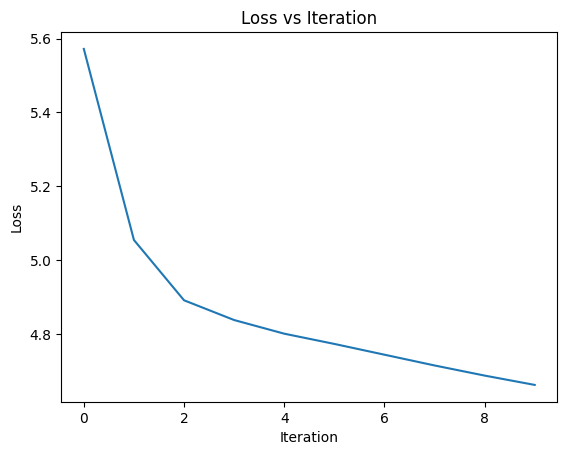

In [43]:
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

---
### Use Simple CNN for Image Classificaiton on MNIST

In [44]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [45]:
# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [46]:
# Define the classes to include in the dataset and the number of samples to select per class
classes_to_include = [0, 1, 2]
num_samples_per_class = 100

In [47]:
# Filter training and testing datasets based on the selected classes
train_filter = np.isin(y_train, classes_to_include)
test_filter = np.isin(y_test, classes_to_include)
X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]

In [48]:
def select_random_samples(X, y, classes, num_samples):

    # Lists to store the selected samples
    selected_X, selected_y = [], []

    for label in classes:
        indices = np.where(y == label)[0] # Find indices where the class matches
        selected_indices = np.random.choice(indices, num_samples, replace = False) # Randomly pick samples
        selected_X.append(X[selected_indices])
        selected_y.append(y[selected_indices])

    return np.concatenate(selected_X), np.concatenate(selected_y)

In [49]:
# Apply the function to the training and testing sets
X_train, y_train = select_random_samples(X_train, y_train, classes_to_include, num_samples_per_class)
X_test, y_test = select_random_samples(X_test, y_test, classes_to_include, num_samples_per_class)

In [50]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (300, 28, 28)
Training labels shape: (300,)
Testing data shape: (300, 28, 28)
Testing labels shape: (300,)


In [51]:
def one_hot_encode(y, num_classes):

    # Convert labels to one-hot encoded vectors
    encoded_vectors = np.eye(num_classes)[y]

    return encoded_vectors

In [52]:
# Perform one-hot encoding on the labels
np.random.seed(1)
n_x = 28
n_y = len(classes_to_include)
cnn = SimpleCNN(n_x, n_y, act = ReLU())
learning_rate = 0.01

In [53]:
# One-hot encode the training and testing labels
y_train = one_hot_encode(y_train, n_y)
y_test = one_hot_encode(y_test, n_y)

In [54]:
# Lists to store the training and testing loss
train_loss = []
test_loss = []

for i in range(50):
    output = cnn.forward(X_test) # Perform forward pass on the test set
    test_loss.append(compute_cost(output, y_test)) # Compute the test loss
    output = cnn.forward(X_train) # Perform forward pass on the training set
    train_loss.append(compute_cost(output, y_train)) # Compute the training loss
    dA3 = (output - y_train) / len(X_train) # Compute the gradient of the cost with respect to the output
    cnn.backward(dA3) # Perform backward pass to calculate gradients for all layers
    gradient_descent_step(cnn.get_params(), cnn.get_grads(), learning_rate) # Update the parameters using gradient descent

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")

Iteration 0, Train Loss: 0.4898658450030681, Test Loss: 0.4909915579443834
Iteration 10, Train Loss: 0.4534920841901883, Test Loss: 0.4545258102229708
Iteration 20, Train Loss: 0.42013601041580223, Test Loss: 0.42133962269998987
Iteration 30, Train Loss: 0.39899389071415486, Test Loss: 0.4001379423308907
Iteration 40, Train Loss: 0.3862471534182913, Test Loss: 0.3868786563817627


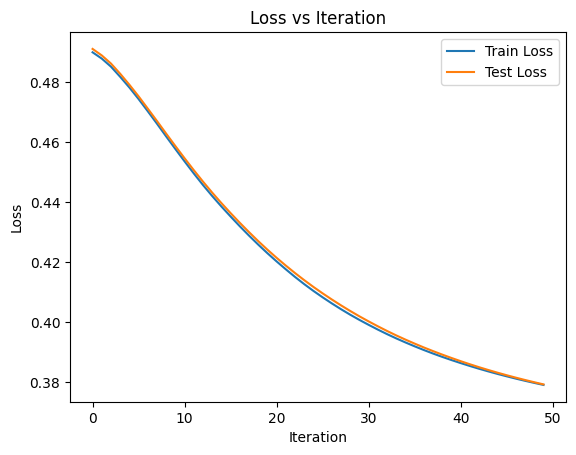

In [55]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.legend()
plt.show()

---
## Semantic Image

---
### UNet Model

**Exercise 9 [5/5]**:
1. Implement the `conv_block()` method using `nn.Sequential()`.

In [56]:
def conv_block(in_channels, out_channels):

    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True),
                         nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True))

In [57]:
# Check if a GPU is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
# Define input and output channels for the convolutional block
in_channels = 3
out_channels = 64

In [59]:
torch.manual_seed(1)
input_tensor = torch.randn(1, in_channels, 256, 256) # Create a random input tensor
conv_block_instance = conv_block(in_channels, out_channels) # Instantiate the convolutional block and move it to the appropriate device
output_tensor = conv_block_instance(input_tensor) # Pass the input tensor through the convolutional block

In [60]:
print(f"Using device: {device}")
print("Output shape:", output_tensor.shape)
print(f"otuput: {output_tensor[:, 0, :, :]}")

Using device: cuda
Output shape: torch.Size([1, 64, 256, 256])
otuput: tensor([[[0.0000, 0.1997, 0.0000,  ..., 0.2494, 0.4599, 0.2160],
         [0.0000, 0.2631, 0.0000,  ..., 0.0996, 0.0000, 0.1223],
         [0.0006, 0.2564, 0.3777,  ..., 0.3040, 0.2214, 0.0000],
         ...,
         [0.1491, 0.0268, 0.0120,  ..., 0.0000, 0.1029, 0.0000],
         [0.1466, 0.0000, 0.2036,  ..., 0.0000, 0.0421, 0.2388],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       grad_fn=<SliceBackward0>)


**Exercise 10 [35/35]**:
1. Implement the class `UNet`.

In [61]:
class UNet(nn.Module):

    # Initialize the U-Net model with input channels, output channels, and feature sizes for each layer
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]):

        # Initialize the parent class
        super(UNet, self).__init__()

        # Encoder section
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Max pooling layer for downsampling

        # Create encoder layers
        for feature in features:
            self.encoder.append(self._conv_block(in_channels, feature))
            in_channels = feature # Update in_channels for the next layer

        # Bottleneck section
        self.bottleneck = self._conv_block(features[-1], features[-1] * 2)

        # Decoder section
        self.decoder = nn.ModuleList()
        self.upconvs = nn.ModuleList()

        # Create decoder layers and upconv layers
        for feature in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size = 2, stride = 2))
            self.decoder.append(self._conv_block(feature * 2, feature))

        # Final convolution layer to reduce the number of output channels to the desired output size
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    # Forward pass through the network
    def forward(self, x):

        # List to store activations from the encoder for skip connections
        encodings = []

        # Encoder forward pass with max pooling
        for layer in self.encoder:
            x = layer(x)
            encodings.append(x)  # Save the output for skip connection
            x = self.pool(x)  # Downsample using max pooling

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse the encoder list to use in the decoder
        encodings = encodings[::-1]

        # Decoder with upsampling and skip connections
        for encoding, norm_conv, upconv in zip(encodings, self.decoder, self.upconvs):

            # Upsample using transposed convolution
            x = upconv(x)

            # If the shapes do not match, crop the encoder output to match the current feature map
            if x.shape != encoding.shape:
                encoding = self.center_crop(encoding, x.shape[2], x.shape[3])

            # Concatenate the upsampled feature map with the encoder feature map
            x = torch.cat((x, encoding), dim = 1)
            x = norm_conv(x)

        # Final convolution to reduce the number of output channels to the desired output channels
        x = self.final_conv(x)

        return x

    # Define a helper function to create a convolutional block
    def _conv_block(self, in_channels, out_channels):
        return conv_block(in_channels, out_channels)

    # Define a helper function to center crop the encoder feature map to match the target size
    def center_crop(self, encoding, target_height, target_width):

        # Get the dimensions of the encoding
        _, _, h, w = encoding.size()

        # Calculate the amount to crop from the top and left to match target height and width
        diff_y = (h - target_height) // 2
        diff_x = (w - target_width) // 2

        return encoding[:, :, diff_y:(diff_y + target_height), diff_x:(diff_x + target_width)]

In [62]:
# Check if GPU is available, else use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
torch.manual_seed(1)
model = UNet(in_channels = 3, out_channels = 1).to(device)

In [64]:
print(f"Using device: {device}")
print(model)

Using device: cuda
UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): R

---
### Load Dataset

In [65]:
class ToIntMask:

    # Allows instances of the class to be used as a function
    def __call__(self, mask):

        mask = F.pil_to_tensor(mask).long() # Convert the PIL mask image to a tensor and cast it to long type
        squeeze = mask.squeeze(0) - 1 # Squeeze the tensor and subtract 1 to make sure labels start from 0

        return squeeze

In [66]:
# Define transformations for images and masks
image_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

In [67]:
# For masks, resize and apply the custom ToIntMask transformation
mask_transform = transforms.Compose([transforms.Resize((128, 128)), ToIntMask()])

In [68]:
# Load the OxfordIIITPet dataset for training and testing with segmentation task
train_dataset = OxfordIIITPet(root = './data',
                              split = 'trainval',
                              target_types = 'segmentation',
                              transform = image_transform,
                              target_transform = mask_transform,
                              download = True)
test_dataset = OxfordIIITPet(root = './data',
                             split = 'test',
                             target_types = 'segmentation',
                             transform = image_transform,
                             target_transform = mask_transform,
                             download = True)

In [69]:
# Define DataLoader to load the dataset in batches
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [70]:
# Load a single batch of images and masks for both training and testing
train_images, train_masks = next(iter(train_loader))
test_images, test_masks = next(iter(test_loader))

In [71]:
print(f"Train images shape: {train_images.shape}, Train masks shape: {train_masks.shape}")
print(f"Test images shape: {test_images.shape}, Test masks shape: {test_masks.shape}")

Train images shape: torch.Size([128, 3, 128, 128]), Train masks shape: torch.Size([128, 128, 128])
Test images shape: torch.Size([128, 3, 128, 128]), Test masks shape: torch.Size([128, 128, 128])


In [72]:
# Select an image from the training batch for visualization
torch.manual_seed(1)
idx = 0
image_pil = F.to_pil_image(train_images[idx])

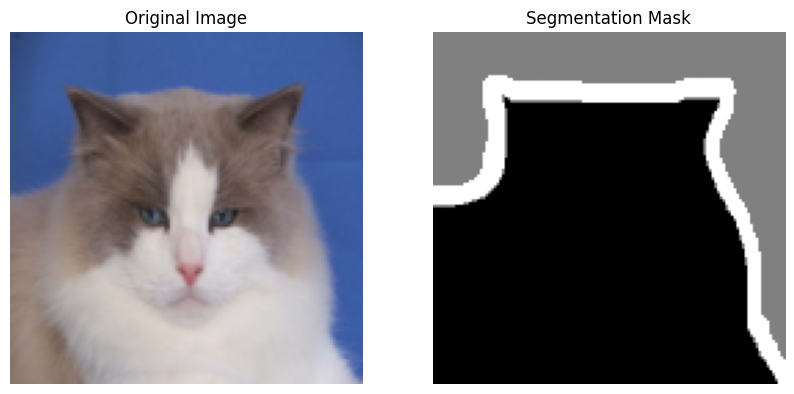

In [73]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_masks[idx].squeeze(), cmap = "gray")
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()

---
### Train and Predict

In [74]:
def train(model, optimizer, criterion, train_loader, device, num_epochs = 10, scheduler = None):

    # List to store the loss at each epoch
    losses = []

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Iterate through the training data in batches
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate the average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1} / {num_epochs}], Loss: {epoch_loss}")

        # Update the learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()

    return losses

In [75]:
# Check if GPU is available, else use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
# Initialize model, criterion, and optimizer
torch.manual_seed(1)
model = UNet(in_channels = 3, out_channels = 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [77]:
print(f"Using device: {device}")
print("Training...")
train_losses = train(model, optimizer, criterion, train_loader, device, num_epochs = 10)

Using device: cuda
Training...
Epoch [1 / 10], Loss: 0.9369319060753132
Epoch [2 / 10], Loss: 0.8897877787721569
Epoch [3 / 10], Loss: 0.7778486938312136
Epoch [4 / 10], Loss: 0.7100290347789896
Epoch [5 / 10], Loss: 0.7006791049036486
Epoch [6 / 10], Loss: 0.6856062453368614
Epoch [7 / 10], Loss: 0.6650851862183933
Epoch [8 / 10], Loss: 0.6460160736379952
Epoch [9 / 10], Loss: 0.6329017569278849
Epoch [10 / 10], Loss: 0.6244098708547395


In [78]:
def plot_predictions_grid(images, masks, predicted_masks, num_samples = 9):

    # Create a subplot grid to show multiple images, masks, and predictions
    fig, axes = plt.subplots(num_samples, 3, figsize = (9, 3 * num_samples))

    # Loop through the samples to plot the images, ground truth masks, and predicted masks
    for idx in range(num_samples):

        # Convert image tensor, ground truth mask tensor, and predicted mask to numpy
        image = images[idx].cpu().permute(1, 2, 0).numpy()
        mask = masks[idx].cpu().numpy().squeeze()
        predicted = predicted_masks[idx].cpu().numpy().squeeze()

        # Plot the original image
        axes[idx, 0].imshow(image)
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title("Original Image")

        # Plot the ground truth mask
        axes[idx, 1].imshow(mask, cmap = 'gray')
        axes[idx, 1].axis('off')
        axes[idx, 1].set_title("Ground Truth Mask")

        # Plot the predicted mask
        axes[idx, 2].imshow(predicted, cmap = 'gray')
        axes[idx, 2].axis('off')
        axes[idx, 2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()

In [79]:
# Evaluate the model on a batch of images from the training set
model.eval()
images, masks = next(iter(train_loader))
images = images.to(device)

In [80]:
# Disable gradient calculation for inference
with torch.no_grad():
    predictions = model(images)

In [81]:
# Get the predicted masks by selecting the class with the highest probability
predicted_masks = torch.argmax(predictions, dim = 1)

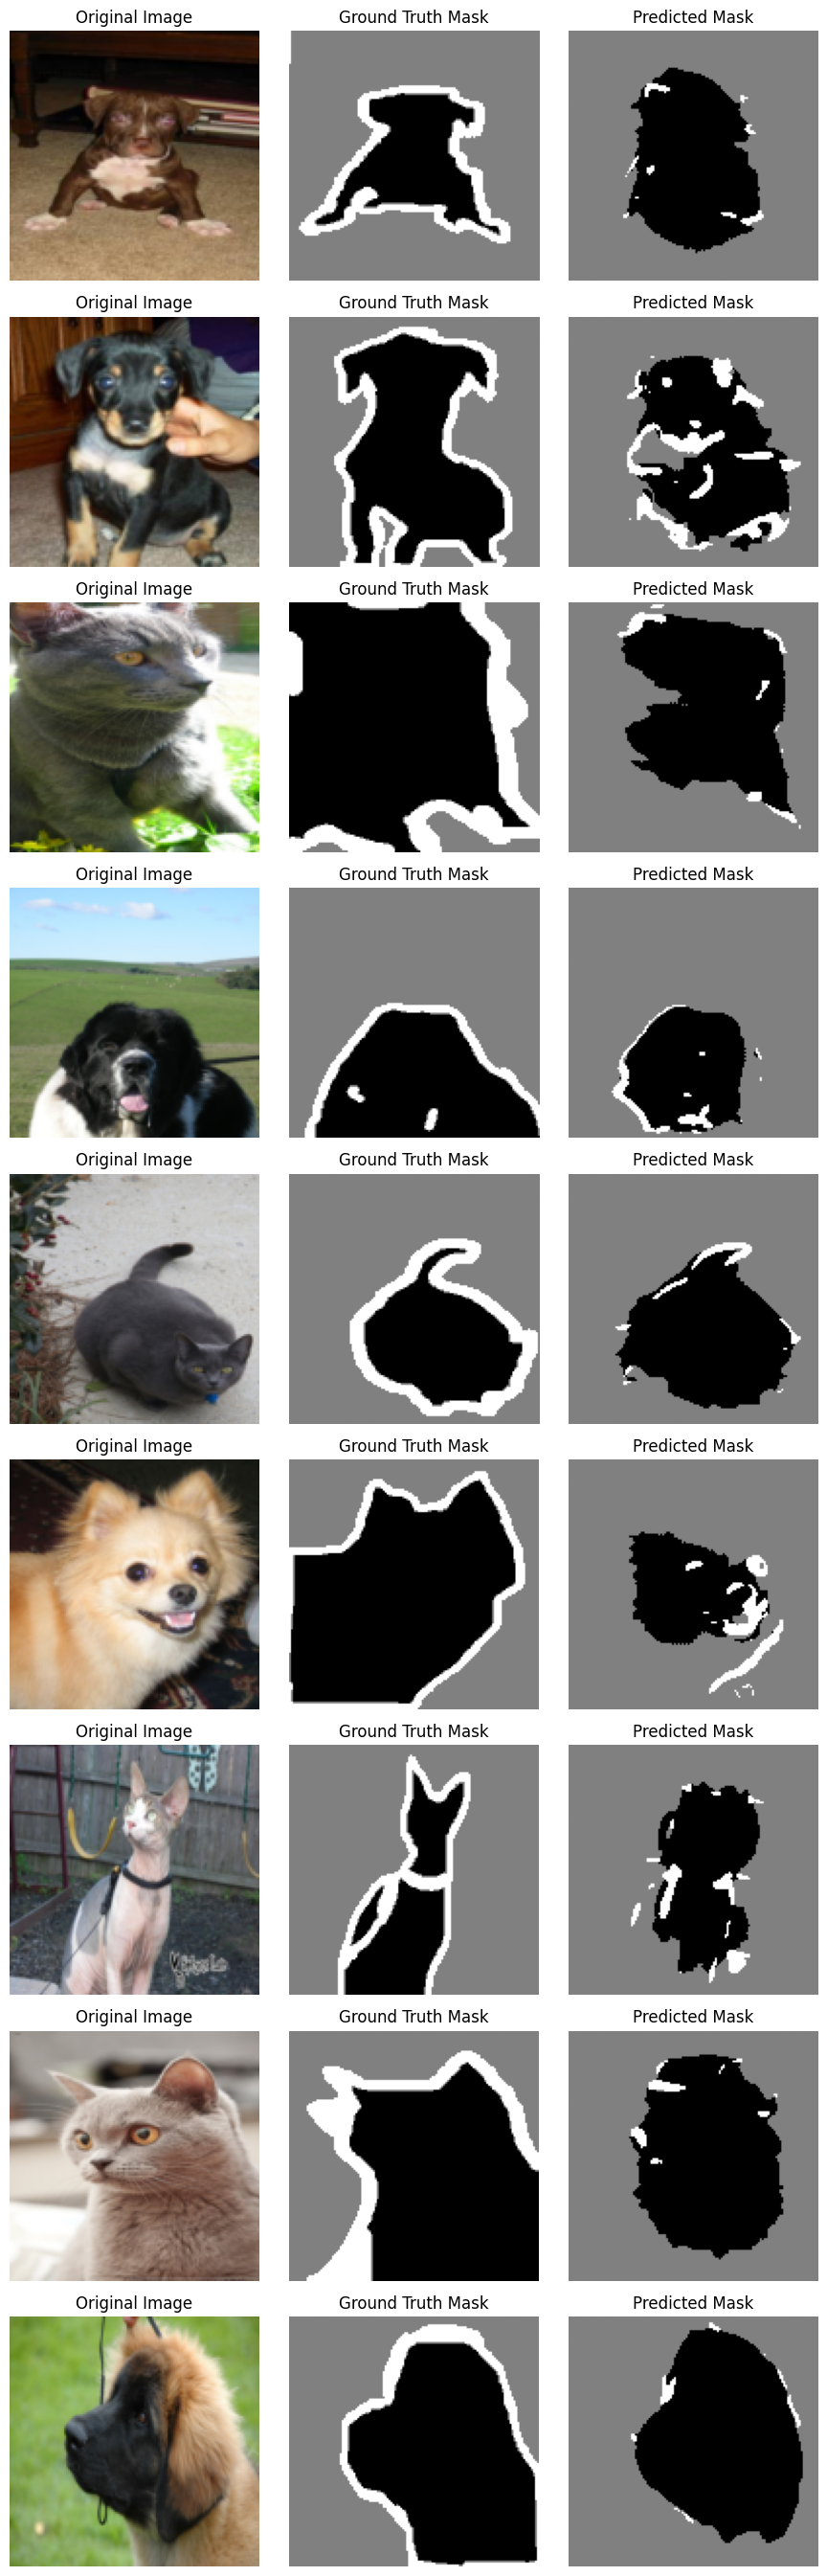

In [82]:
plot_predictions_grid(images, masks, predicted_masks)

In [83]:
# Evaluate the model on a batch of images from the test  set
model.eval()
images, masks = next(iter(test_loader))
images = images.to(device)

In [84]:
# Disable gradient calculation for inference
with torch.no_grad():
    predictions = model(images)

In [85]:
# Get the predicted masks by selecting the class with the highest probability
predicted_masks = torch.argmax(predictions, dim = 1)

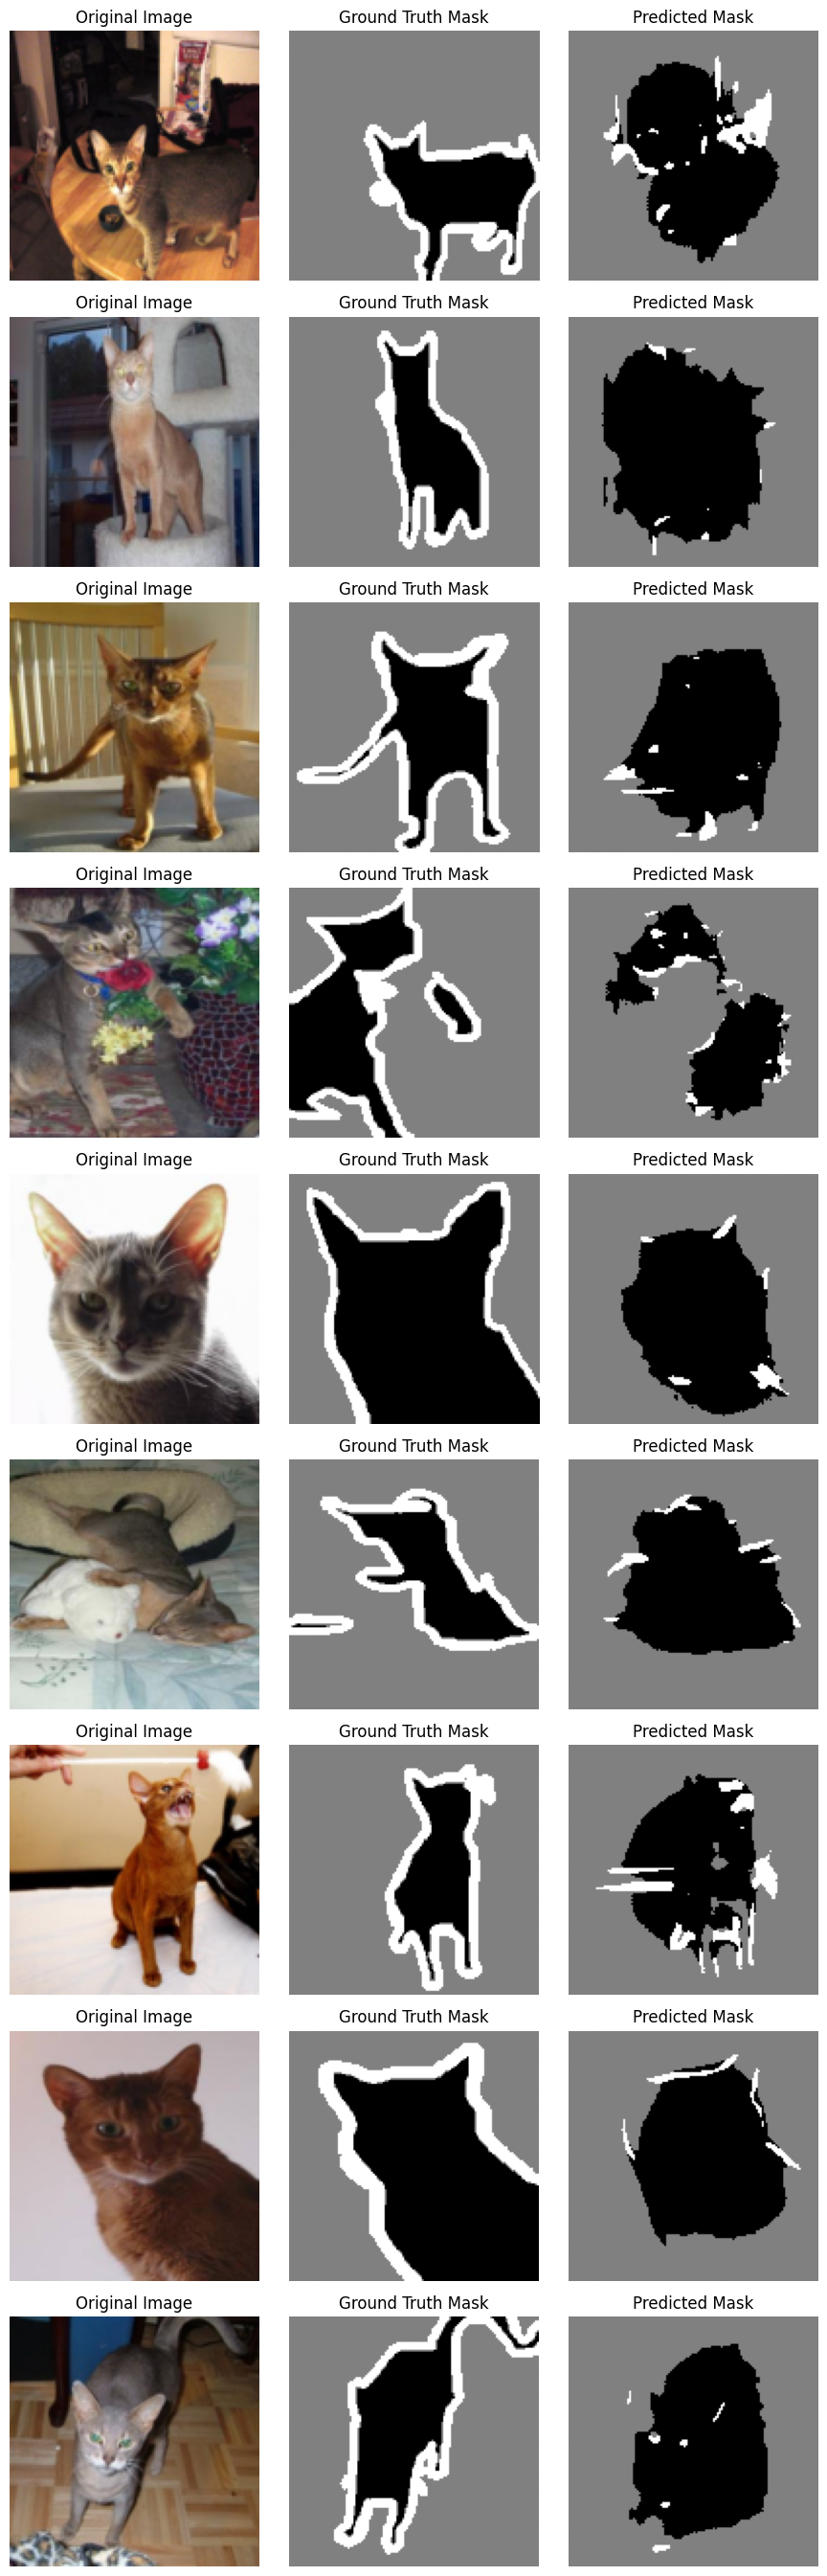

In [86]:
plot_predictions_grid(images, masks, predicted_masks)

---
### Save and Load Model

In [87]:
# Define the path
checkpoint_path_100 = r'C:\Users\wodnj\OneDrive\바탕 화면\DePaul Univ\24&25-02 Winter\Neural Networks and Deep Learning\CSC 578 - Week 5\checkpoint_epoch_100.pth'

In [88]:
# Check if the checkpoint file exists, if not, create it
if not os.path.exists(checkpoint_path_100):
    print(f"Checkpoint not found. Saving model at '{checkpoint_path_100}'")

    # Save the model and optimizer state at epoch 100
    torch.save({'epoch': 100,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_losses,},
                checkpoint_path_100)
    print(f"Model saved to {checkpoint_path_100}")

else:
    print(f"Model already exists at {checkpoint_path_100}. No new model saved.")

Checkpoint not found. Saving model at 'C:\Users\wodnj\OneDrive\바탕 화면\DePaul Univ\24&25-02 Winter\Neural Networks and Deep Learning\CSC 578 - Week 5\checkpoint_epoch_100.pth'
Model saved to C:\Users\wodnj\OneDrive\바탕 화면\DePaul Univ\24&25-02 Winter\Neural Networks and Deep Learning\CSC 578 - Week 5\checkpoint_epoch_100.pth


In [89]:
# Loading a saved checkpoint
checkpoint = torch.load(checkpoint_path_100)

<ipython-input-89-1b26b848ccc6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path_100)


In [90]:
# Load the model and optimizer states from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [91]:
# Set the model back to training mode
model.train()

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
 

In [92]:
# Set the starting epoch from the checkpoint
start_epoch = checkpoint['epoch']